 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 6. MLP Basis**
# Section 4. Neural Network Modeling

### _Objective_
1. 신경망의 이론적 근거인 보편 근사 정리에 대해 배워봅니다.<br>
2. 신경망이 넓어질수록 어떤 효과가 있는지 배워봅니다. <br>
3. 신경망이 깊어질수록 어떤 효과가 있는지 배워봅니다. <br>
  
╚═════════════════════════════════════════╝

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf
tf.random.set_random_seed(252)
np.random.seed(100)

import matplotlib.pyplot as plt
from tqdm import tqdm

### [Optional.  Tensorflow Graph Visualization ]

---

> _Jupyter에서 Tensorflow에서 구성되는 Graph를 시각적으로 보여주기 위한 helper 메소드입니다._<br>

In [0]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))

    display(HTML(iframe))

<br>
<br>
# [ 1. Universial Approximation Theorem ]
----
----

![Imgur](https://i.imgur.com/Ha4ubDo.png)


<br>

## 1.  보편 근사 정리 의미 (시벤코 정리)

----

* 이 정리는 하나의 은닉층을 갖는 인공신경망은 임의의 연속인 다변수 함수를 원하는 정도의 정확도로 근사할 수 있음을 말한다. 단 $w_1$,$w_2$,....,$w_N$, $\alpha$와 $\theta$를 잘못 선택하거나 은닉층의 뉴런 수가 부족할 경우 충분한 정확도로 근사하는 데 실패할 수 있다.

<br>

## 2. 임의의 2차 함수 근사하기


### (1) 임의의 2차 함수 만들기

In [0]:
func = lambda x : 2*x**2-1*x-0.5 # 임의의 2차 함수 근사

xs = np.linspace(0,1,1000)
ys = func(xs)

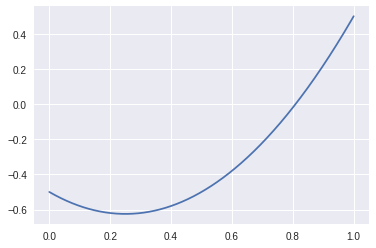

In [0]:
plt.plot(xs,ys)
plt.show()

### (2) 학습시킬 2층짜리 Neural Network 만들기

In [0]:
tf.reset_default_graph()

# Data를 받아오는 placeholder
x = tf.placeholder(tf.float32, shape=(None,1), name='x')
y_true = tf.placeholder(tf.float32, shape=(None,1), name="y_true")

with tf.variable_scope('hidden_layer'):
    w1 = tf.Variable(tf.random.normal([1,200],stddev=0.1),
                     name='weight')
    b1 = tf.Variable(tf.zeros([200]),name='bias')
    
    z1 = tf.matmul(x,w1) + b1
    a1 = tf.nn.relu(z1)

with tf.variable_scope('output_layer'):
    w2 = tf.Variable(tf.random.normal([200,1],stddev=0.1),
                     name='weight')
    b2 = tf.Variable(tf.zeros([1]),name='bias')
    
    y_pred = tf.matmul(a1,w2) + b2

y_pred = tf.identity(y_pred,name="y_pred")
    
with tf.variable_scope("loss"):
    mse = tf.reduce_mean((y_pred-y_true)**2)
    tf.add_to_collection(tf.GraphKeys.LOSSES,mse)
    
train_op = (tf.train
            .AdamOptimizer(0.01)
            .minimize(mse))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
show_graph(tf.get_default_graph())

### (3) Neural Network 학습하기

In [0]:
graph = tf.get_default_graph()

x = graph.get_tensor_by_name('x:0')
y = graph.get_tensor_by_name('y_true:0')
y_pred = graph.get_tensor_by_name('y_pred:0')
loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
train_op = graph.get_collection(tf.GraphKeys.TRAIN_OP)[0]

sess = tf.Session(graph=graph)

# 변수 초기화하기
sess.run(tf.global_variables_initializer())

loss_history = []
for epoch in tqdm(range(10000)):
    _, loss_value = sess.run([train_op, loss],
             feed_dict={
                 x:xs.reshape(-1,1),
                 y:ys.reshape(-1,1)
             })
    loss_history.append(loss_value)

100%|██████████| 10000/10000 [00:15<00:00, 627.51it/s]


In [0]:
ys_pred = sess.run(y_pred,feed_dict={
    x:xs.reshape(-1,1)
})

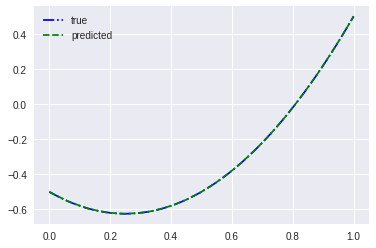

In [0]:
plt.plot(xs,ys,'b-.')
plt.plot(xs,ys_pred,'g--')
plt.legend(['true','predicted'])
plt.show()

> 완벽하진 않지만 어느정도 근사되어감을 알 수 있습니다.

<br>

## 2. 임의의 5차 함수 근사하기


### (1) 임의의 5차 함수 만들기

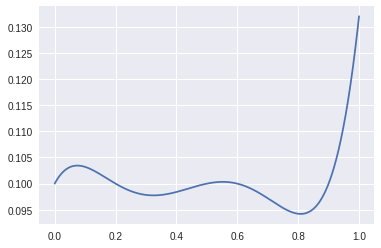

In [0]:
func = lambda x : 2*x*(x-0.2)*(x-0.5)*(x-0.6)*(x-.9)+0.1 # 임의의 2차 함수 근사

xs = np.linspace(0,1,1000)
ys = func(xs)

plt.plot(xs,ys)
plt.show()

### (2) 학습시킬 2층짜리 Neural Network 만들기

In [0]:
tf.reset_default_graph()

# Data를 받아오는 placeholder
x = tf.placeholder(tf.float32, shape=(None,1), name='x')
y_true = tf.placeholder(tf.float32, shape=(None,1), name="y_true")

with tf.variable_scope('hidden_layer'):
    w1 = tf.Variable(tf.random.normal([1,200],stddev=0.1),
                     name='weight')
    b1 = tf.Variable(tf.zeros([200]),name='bias')
    
    z1 = tf.matmul(x,w1) + b1
    a1 = tf.nn.relu(z1)

with tf.variable_scope('output_layer'):
    w2 = tf.Variable(tf.random.normal([200,1],stddev=0.1),
                     name='weight')
    b2 = tf.Variable(tf.zeros([1]),name='bias')
    
    y_pred = tf.matmul(a1,w2) + b2

y_pred = tf.identity(y_pred,name="y_pred")
    
with tf.variable_scope("loss"):
    mse = tf.reduce_mean((y_pred-y_true)**2)
    tf.add_to_collection(tf.GraphKeys.LOSSES,mse)
    
train_op = (tf.train
            .AdamOptimizer(0.01)
            .minimize(mse))

In [0]:
show_graph(tf.get_default_graph())

### (3) Neural Network 학습하기

In [0]:
graph = tf.get_default_graph()

x = graph.get_tensor_by_name('x:0')
y = graph.get_tensor_by_name('y_true:0')
y_pred = graph.get_tensor_by_name('y_pred:0')
loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
train_op = graph.get_collection(tf.GraphKeys.TRAIN_OP)[0]

sess = tf.Session(graph=graph)

# 변수 초기화하기
sess.run(tf.global_variables_initializer())

loss_history = []
for epoch in tqdm(range(10000)): 
    _, loss_value = sess.run([train_op, loss],
             feed_dict={
                 x:xs.reshape(-1,1),
                 y:ys.reshape(-1,1)
             })
    loss_history.append(loss_value)

100%|██████████| 10000/10000 [00:16<00:00, 618.95it/s]


In [0]:
ys_pred = sess.run(y_pred,feed_dict={
    x:xs.reshape(-1,1)
})

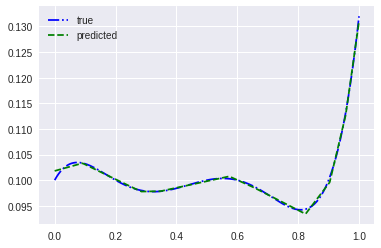

In [0]:
plt.plot(xs,ys,'b-.')
plt.plot(xs,ys_pred,'g--')
plt.legend(['true','predicted'])
plt.show()

> 동일한 모델로 2차 함수를 근사하듯, 5차함수도 근사할 수 있습니다.

<br>

## 3. 임의의 삼각함수 근사하기
----


### (1) 임의의 삼각함수

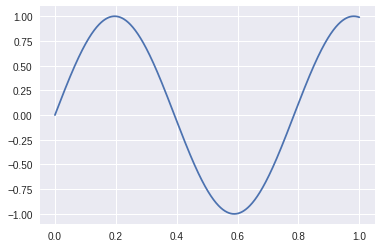

In [0]:
func = lambda x : np.sin(8*x) # 임의의 2차 함수 근사

xs = np.linspace(0,1,1000)
ys = func(xs)

plt.plot(xs,ys)
plt.show()

### (2) 학습시킬 2층짜리 Neural Network 만들기

In [0]:
tf.reset_default_graph()

# Data를 받아오는 placeholder
x = tf.placeholder(tf.float32, shape=(None,1), name='x')
y_true = tf.placeholder(tf.float32, shape=(None,1), name="y_true")

with tf.variable_scope('hidden_layer'):
    w1 = tf.Variable(tf.random.normal([1,200],stddev=0.1),
                     name='weight')
    b1 = tf.Variable(tf.zeros([200]),name='bias')
    
    z1 = tf.matmul(x,w1) + b1
    a1 = tf.nn.relu(z1)

with tf.variable_scope('output_layer'):
    w2 = tf.Variable(tf.random.normal([200,1],stddev=0.1),
                     name='weight')
    b2 = tf.Variable(tf.zeros([1]),name='bias')
    
    y_pred = tf.matmul(a1,w2) + b2

y_pred = tf.identity(y_pred,name="y_pred")
    
with tf.variable_scope("loss"):
    mse = tf.reduce_mean((y_pred-y_true)**2)
    tf.add_to_collection(tf.GraphKeys.LOSSES,mse)
    
train_op = (tf.train
            .AdamOptimizer(0.01)
            .minimize(mse))

In [0]:
show_graph(tf.get_default_graph())

### (3) Neural Network 학습하기

In [0]:
graph = tf.get_default_graph()

x = graph.get_tensor_by_name('x:0')
y = graph.get_tensor_by_name('y_true:0')
y_pred = graph.get_tensor_by_name('y_pred:0')
loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
train_op = graph.get_collection(tf.GraphKeys.TRAIN_OP)[0]

sess = tf.Session(graph=graph)

# 변수 초기화하기
sess.run(tf.global_variables_initializer())

loss_history = []
for epoch in tqdm(range(10000)):
    _, loss_value = sess.run([train_op, loss],
             feed_dict={
                 x:xs.reshape(-1,1),
                 y:ys.reshape(-1,1)
             })
    loss_history.append(loss_value)

100%|██████████| 10000/10000 [00:15<00:00, 633.19it/s]


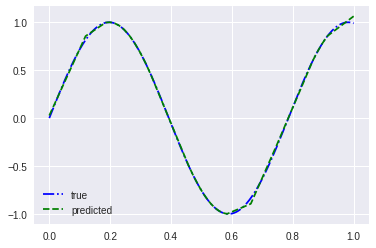

In [0]:
ys_pred = sess.run(y_pred,feed_dict={
    x:xs.reshape(-1,1)
})

plt.plot(xs,ys,'b-.')
plt.plot(xs,ys_pred,'g--')
plt.legend(['true','predicted'])
plt.show()

* 매우 잘 근사합니다.

----

<br><br>

# \[ 2. 넓어짐과 깊어짐 \]

----

----

> *시벤코 정리에 따르면, 주어진 함수를 우리가 원하는 정확도로 근사할 수 있는 Neural Network는 존재한다는 것이 증명됩니다.*<br>
> *Neural Network의 Architecture를 결정하는 가장 큰 요소는 Node 수와 Layer 수입니다. 각각의 갯수가 늘어났을 떄 어떤 식으로 변화하는지 살펴보겠습니다.*<br>



## 1. 신경망을 Wide 하게 구성하는 효과
----

<br>
* 신경망이 Wide해진다는 표현은 주로 unit의 수가 늘어날 때 쓰는 표현입니다. 
* unit의 수를 10개일 때, 1000개일 때, 어떤 식으로 변화하는지 보겠습니다.

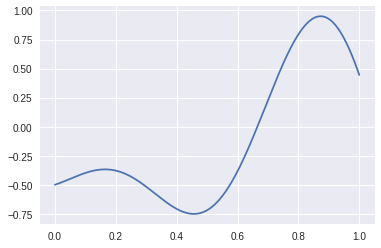

In [0]:
func = lambda x : x*x*np.sin(2*x+0.5)+x*np.cos(8*x-0.5) -0.5 

xs = np.linspace(0,1,1000)
ys = func(xs)

plt.plot(xs,ys)
plt.show()

## (1) unit 수가 10개짜리 Neural Network 학습하기

In [0]:
# Graph 구성하기
num_units = 10

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None,1), name='x')
y_true = tf.placeholder(tf.float32, shape=(None,1), name="y_true")

with tf.variable_scope('hidden_layer'):
    w1_init = tf.random.normal([1,num_units],
                               stddev=np.sqrt(2/num_units))
    w1 = tf.Variable(w1_init,
                     name='weight')
    b1 = tf.Variable(tf.zeros([num_units]),name='bias')
    
    z1 = tf.matmul(x,w1) + b1
    a1 = tf.nn.relu(z1)

with tf.variable_scope('output_layer'):
    w2_init = tf.random.normal([num_units,1],
                               stddev=np.sqrt(2/num_units))
    w2 = tf.Variable(w2_init,
                     name='weight')
    b2 = tf.Variable(tf.zeros([1]),name='bias')
    
    y_pred = tf.matmul(a1,w2) + b2

y_pred = tf.identity(y_pred,name="y_pred")
    
with tf.variable_scope("loss"):
    mse = tf.reduce_mean((y_pred-y_true)**2)
    tf.add_to_collection(tf.GraphKeys.LOSSES,mse)
    
# Gradient Descent와 비슷
train_op = (tf.train
            .AdamOptimizer(0.01)
            .minimize(mse))

In [0]:
# Graph 학습하기
graph = tf.get_default_graph()

x = graph.get_tensor_by_name('x:0')
y = graph.get_tensor_by_name('y_true:0')
y_pred = graph.get_tensor_by_name('y_pred:0')
loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
train_op = graph.get_collection(tf.GraphKeys.TRAIN_OP)[0]

sess = tf.Session(graph=graph)

sess.run(tf.global_variables_initializer())

loss_history = []
for epoch in tqdm(range(30000)):
    _, loss_value = sess.run(
        [train_op, loss],
            feed_dict={
                 x:xs.reshape(-1,1),
                 y:ys.reshape(-1,1)
             })
    loss_history.append(loss_value)

100%|██████████| 30000/30000 [00:44<00:00, 670.50it/s]


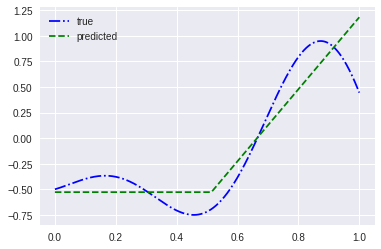

In [0]:
# 학습된 모델 돌리기
ys_pred = sess.run(y_pred,feed_dict={
    x:xs.reshape(-1,1)
})

plt.plot(xs,ys,'b-.')
plt.plot(xs,ys_pred,'g--')
plt.legend(['true','predicted'])
plt.show()

## (2) unit 수가 1000개짜리 Neural Network 학습하기

In [0]:
# Graph 구성하기
num_units = 100

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None,1), name='x')
y_true = tf.placeholder(tf.float32, shape=(None,1), name="y_true")

with tf.variable_scope('hidden_layer'):
    w1_init = tf.random.normal([1,num_units],
                               stddev=np.sqrt(2/num_units))
    w1 = tf.Variable(w1_init,
                     name='weight')
    b1 = tf.Variable(tf.zeros([num_units]),name='bias')
    
    z1 = tf.matmul(x,w1) + b1
    a1 = tf.nn.relu(z1)

with tf.variable_scope('output_layer'):
    w2_init = tf.random.normal([num_units,1],
                               stddev=np.sqrt(2/num_units))
    w2 = tf.Variable(w2_init,
                     name='weight')
    b2 = tf.Variable(tf.zeros([1]),name='bias')
    
    y_pred = tf.matmul(a1,w2) + b2

y_pred = tf.identity(y_pred,name="y_pred")
    
with tf.variable_scope("loss"):
    mse = tf.reduce_mean((y_pred-y_true)**2)
    tf.add_to_collection(tf.GraphKeys.LOSSES,mse)
    
# Gradient Descent와 비슷
train_op = (tf.train
            .AdamOptimizer(0.01)
            .minimize(mse))

In [0]:
# Graph 학습하기
graph = tf.get_default_graph()

x = graph.get_tensor_by_name('x:0')
y = graph.get_tensor_by_name('y_true:0')
y_pred = graph.get_tensor_by_name('y_pred:0')
loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
train_op = graph.get_collection(tf.GraphKeys.TRAIN_OP)[0]

sess = tf.Session(graph=graph)

sess.run(tf.global_variables_initializer())

loss_history = []
for epoch in tqdm(range(10000)):
    _, loss_value = sess.run(
        [train_op, loss],
            feed_dict={
                 x:xs.reshape(-1,1),
                 y:ys.reshape(-1,1)
             })
    loss_history.append(loss_value)

100%|██████████| 10000/10000 [00:15<00:00, 662.13it/s]


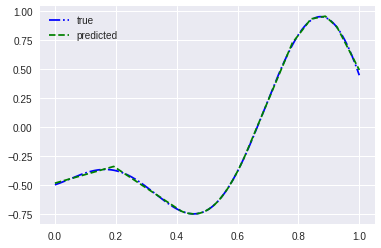

In [0]:
# 학습된 모델 돌리기
ys_pred = sess.run(y_pred,feed_dict={
    x:xs.reshape(-1,1)
})

plt.plot(xs,ys,'b-.')
plt.plot(xs,ys_pred,'g--')
plt.legend(['true','predicted'])
plt.show()

> 갯수가 늘수록 근사한다는 것을 알 수 있습니다.

## 2. 신경망을 깊게 구성하는 효과
----

<br>
* 신경망이 깊어진다는 표현은 주로 Layer의 수가 늘어날 때 쓰는 표현입니다. 
* Node의 수가 100개짜리인 것 1개와 10개짜리 인것 2개의 차이를 봅니다.

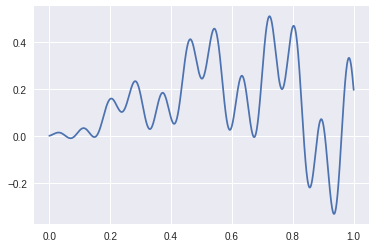

In [0]:
func = lambda x : x*(np.sin(24*x+0.5)*np.cos(48*x-0.5)+np.sin(3*x+0.3))/2

xs = np.linspace(0,1,1000)
ys = func(xs)

plt.plot(xs,ys)
plt.show()

### (1) 1000개짜리 hidden Layer가 1층일 경우

In [0]:
# Graph 구성하기
num_units = 1000

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None,1), name='x')
y_true = tf.placeholder(tf.float32, shape=(None,1), name="y_true")

with tf.variable_scope('hidden_layer'):
    w1_init = tf.random.normal([1,num_units],
                               stddev=np.sqrt(2/num_units))
    w1 = tf.Variable(w1_init,
                     name='weight')
    b1 = tf.Variable(tf.zeros([num_units]),name='bias')
    
    z1 = tf.matmul(x,w1) + b1
    a1 = tf.nn.relu(z1)

with tf.variable_scope('output_layer'):
    w2_init = tf.random.normal([num_units,1],
                               stddev=np.sqrt(2/num_units))
    w2 = tf.Variable(w2_init,
                     name='weight')
    b2 = tf.Variable(tf.zeros([1]),name='bias')
    
    y_pred = tf.matmul(a1,w2) + b2

y_pred = tf.identity(y_pred,name="y_pred")
    
with tf.variable_scope("loss"):
    mse = tf.reduce_mean((y_pred-y_true)**2)
    tf.add_to_collection(tf.GraphKeys.LOSSES,mse)
    
# Gradient Descent와 비슷
train_op = (tf.train
            .AdamOptimizer(0.01)
            .minimize(mse))

In [0]:
# Graph 학습하기
graph = tf.get_default_graph()

x = graph.get_tensor_by_name('x:0')
y = graph.get_tensor_by_name('y_true:0')
y_pred = graph.get_tensor_by_name('y_pred:0')
loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
train_op = graph.get_collection(tf.GraphKeys.TRAIN_OP)[0]

sess = tf.Session(graph=graph)

sess.run(tf.global_variables_initializer())

loss_history = []
for epoch in tqdm(range(20000)):
    _, loss_value = sess.run(
        [train_op, loss],
            feed_dict={
                 x:xs.reshape(-1,1),
                 y:ys.reshape(-1,1)
             })
    loss_history.append(loss_value)

100%|██████████| 20000/20000 [00:37<00:00, 536.14it/s]


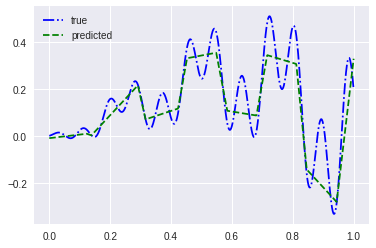

In [0]:
# 학습된 모델 돌리기
ys_pred = sess.run(y_pred,feed_dict={
    x:xs.reshape(-1,1)
})

plt.plot(xs,ys,'b-.')
plt.plot(xs,ys_pred,'g--')
plt.legend(['true','predicted'])
plt.show()

### (2) 20개짜리 hidden Layer가 3층인 경우

In [0]:
# Graph 구성하기
num_units = 20

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None,1), name='x')
y_true = tf.placeholder(tf.float32, shape=(None,1), name="y_true")

with tf.variable_scope('hidden1'):
    w1_init = tf.random.normal([1,num_units],
                               stddev=np.sqrt(2/num_units))
    w1 = tf.Variable(w1_init,
                     name='weight')
    b1 = tf.Variable(tf.zeros([num_units]),name='bias')
    
    z1 = tf.matmul(x,w1) + b1
    a1 = tf.nn.relu(z1)
    
with tf.variable_scope('hidden2'):
    w2_init = tf.random.normal([num_units, num_units],
                               stddev=np.sqrt(2/num_units))
    w2 = tf.Variable(w2_init,
                     name='weight')
    b2 = tf.Variable(tf.zeros([num_units]),name='bias')
    
    z2 = tf.matmul(a1,w2) + b2
    a2 = tf.nn.relu(z2)

with tf.variable_scope('hidden3'):
    w3_init = tf.random.normal([num_units, num_units],
                               stddev=np.sqrt(2/num_units))
    w3 = tf.Variable(w3_init,
                     name='weight')
    b3 = tf.Variable(tf.zeros([num_units]),name='bias')
    
    z3 = tf.matmul(a2,w3) + b3
    a3 = tf.nn.relu(z3)
    
with tf.variable_scope('output_layer'):
    wo_init = tf.random.normal([num_units,1],
                               stddev=np.sqrt(2/num_units))
    wo = tf.Variable(wo_init,
                     name='weight')
    bo = tf.Variable(tf.zeros([1]),name='bias')
    
    y_pred = tf.matmul(a3,wo) + bo

y_pred = tf.identity(y_pred,name="y_pred")
    
with tf.variable_scope("loss"):
    mse = tf.reduce_mean((y_pred-y_true)**2)
    tf.add_to_collection(tf.GraphKeys.LOSSES,mse)
    
# Gradient Descent와 비슷
train_op = (tf.train
            .AdamOptimizer(0.01)
            .minimize(mse))


In [0]:
# Graph 학습하기
graph = tf.get_default_graph()

x = graph.get_tensor_by_name('x:0')
y = graph.get_tensor_by_name('y_true:0')
y_pred = graph.get_tensor_by_name('y_pred:0')
loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
train_op = graph.get_collection(tf.GraphKeys.TRAIN_OP)[0]

sess = tf.Session(graph=graph)

sess.run(tf.global_variables_initializer())

loss_history = []
for epoch in tqdm(range(20000)):
    _, loss_value = sess.run(
        [train_op, loss],
            feed_dict={
                 x:xs.reshape(-1,1),
                 y:ys.reshape(-1,1)
             })
    loss_history.append(loss_value)

100%|██████████| 20000/20000 [00:43<00:00, 464.16it/s]


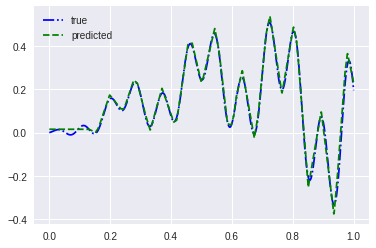

In [0]:
# 학습된 모델 돌리기
ys_pred = sess.run(y_pred,feed_dict={
    x:xs.reshape(-1,1)
})

plt.plot(xs,ys,'b-.')
plt.plot(xs,ys_pred,'g--')
plt.legend(['true','predicted'])
plt.show()

## 신경망의 너비와 깊이의 비교

----


신경망의 unit 수가 증가할수록, 근사하고자 하는 함수와 근사 수준이 높아집니다.<br>
하지만 역으로 지나치게 weight의 수가 증가하기 때문에, Overfitting 문제가 발생하기 쉽습니다.<br>


![Imgur](https://i.imgur.com/udj3bZN.png)

Reference : On the number of Linear Regions of deep Neural Networks

신경망의 깊이가 정확히 어떠한 효과를 가져오는지, 증명된 바는 적지만,<br>
일반적으로 깊이가 깊어질수록, 근사하는 수준이 좋아지고, 일반화효과가 매우<br>
좋아집니다.

현대 많은 신경망들은 너비를 크게 하는 대신, 깊이를 깊게 함으로써,<br>
weight의 수를 줄이고, 일반화효과를 크게 가져가는데에 주력하고 있습니다.

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/02

---